In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rfpimp

from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline
sns.set()

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
def univariate_auc(dataset, variable_name):
    dataset = dataset[[variable_name, "TYPE"]].dropna(how="any").sort_values(by=variable_name, ascending=False)
    binary = np.where(dataset.TYPE == "Disease", 1, 0)
    sorted_variable = dataset[[variable_name]]
    fpr, tpr, _ = roc_curve(binary, sorted_variable)
    return auc(fpr, tpr)

def balanced_accuracy(dataset, variable_name):
    dataset = pd.concat([dataset[[variable_name]].astype('bool'), dataset[["TYPE"]]], axis=1).sort_values(by=variable_name, ascending=False).dropna()
    tp = dataset[(dataset.TYPE == "Disease") & (dataset[variable_name])].shape[0]
    p = dataset[dataset.TYPE == "Disease"].shape[0]
    tn = dataset[(dataset.TYPE == "Polymorphism") & (~dataset[variable_name])].shape[0]
    n = dataset[dataset.TYPE == "Polymorphism"].shape[0]
    return (tp/p + tn/n) / 2

In [3]:
RANDOM_STATE = 42

In [4]:
genomic_dataset = pd.read_csv("../data/processed/genomic/dataset.csv.gz", index_col="MUTANT")
genomic_dataset = genomic_dataset[genomic_dataset.TYPE != "Unclassified"]
# genomic_dataset["random"] = np.random.random(size=len(genomic_dataset))

In [5]:
genomic_dataset.head()

,TYPE,CONS,SNP_DEN,HAPMAP_SNP_DEN,PHYLOP46WAY,PHASTCONS46WAY,INTRON,MISSENSE,NEAR-GENE,NCRNA,CODING-SYNON,UNTRANSLATED,NONSENSE,SPLICE,STOP-LOSS
MUTANT,,,,,,,,,,,,,,,
P04217-52-H-R,Polymorphism,0.551206,0.059259,0.000000,-1.279,0.000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P04217-395-H-R,Polymorphism,0.517549,0.021277,0.000000,-1.011,0.000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9NQ94-555-V-M,Polymorphism,0.621177,0.034152,0.000033,0.117,0.077,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9NQ94-558-A-S,Polymorphism,0.621177,0.034152,0.000033,1.468,0.996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A8K2U0-207-G-R,Polymorphism,0.782358,0.031250,0.000000,0.209,0.873,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
genomic_dataset.shape

(55382, 15)

In [11]:
genomic_dataset[genomic_dataset.PHASTCONS46WAY.isnull()]["TYPE"].value_counts(normalize=True)

Polymorphism    0.728097
Disease         0.271903
Name: TYPE, dtype: float64

In [10]:
genomic_dataset[~genomic_dataset.PHASTCONS46WAY.isnull()]["TYPE"].value_counts(normalize=True)

Polymorphism    0.677563
Disease         0.322437
Name: TYPE, dtype: float64

In [7]:
genomic_dataset.TYPE.value_counts(normalize=True)

Polymorphism    0.67847
Disease         0.32153
Name: TYPE, dtype: float64

In [8]:
genomic_dataset.columns

Index(['TYPE', 'CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WAY',
       'PHASTCONS46WAY', 'INTRON', 'MISSENSE', 'NEAR-GENE', 'NCRNA',
       'CODING-SYNON', 'UNTRANSLATED', 'NONSENSE', 'SPLICE', 'STOP-LOSS'],
      dtype='object')

In [9]:
# genomic_dataset[["CONS","SNP_DEN", "HAPMAP_SNP_DEN"]].describe().iloc[:8].T.to_csv("/home/marlan/Desktop/describe.csv", index=True, index_label="Variable", float_format="%.2f")
genomic_dataset[["CONS","SNP_DEN", "HAPMAP_SNP_DEN"]].describe().iloc[:8].T

,count,mean,std,min,25%,50%,75%,max
CONS,54326.0,0.652634,0.086864,0.144895,0.587777,0.656068,0.71951,0.897386
SNP_DEN,54326.0,0.064620,0.099475,0.000000,0.029703,0.043860,0.06437,1.042402
HAPMAP_SNP_DEN,54326.0,0.000143,0.000994,0.000000,0.000000,0.000000,0.00000,0.039147


In [10]:
le = LabelEncoder()
X = genomic_dataset[~genomic_dataset.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(genomic_dataset[~genomic_dataset.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [11]:
RANDOM_STATE = 42
cat_vars = ['INTRON','MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON', 'UNTRANSLATED',
            'NONSENSE', 'SPLICE', 'STOP-LOSS']

cont_vars = genomic_dataset.columns.drop(cat_vars + ["TYPE"], 1).tolist()

impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  

# impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))

scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state=RANDOM_STATE))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2,7]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [12]:
for variable in cont_vars:
    print(variable, ":", univariate_auc(genomic_dataset, variable))

CONS : 0.6540061843708613
SNP_DEN : 0.5645233271216945
HAPMAP_SNP_DEN : 0.4838488970274762
PHYLOP46WAY : 0.8256757877025457
PHASTCONS46WAY : 0.7839598207027896


In [13]:
genomic_dataset[genomic_dataset.NONSENSE == 1]

,TYPE,CONS,SNP_DEN,HAPMAP_SNP_DEN,PHYLOP46WAY,PHASTCONS46WAY,INTRON,MISSENSE,NEAR-GENE,NCRNA,CODING-SYNON,UNTRANSLATED,NONSENSE,SPLICE,STOP-LOSS
MUTANT,,,,,,,,,,,,,,,
Q8WWZ4-1322-R-W,Polymorphism,0.480702,0.044332,0.000000,-2.227,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Q86UK0-287-R-G,Polymorphism,0.656038,0.033520,0.000000,3.353,0.995,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
P78363-635-Q-K,Disease,0.727741,0.152542,0.000000,4.245,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P78363-991-G-R,Disease,0.709221,0.121212,0.000000,6.334,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P78363-1022-E-K,Disease,0.762110,0.114286,0.000000,6.301,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P78363-1399-E-K,Disease,0.711572,0.112000,0.000000,5.887,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Q96SE0-371-W-C,Polymorphism,0.607797,0.078167,0.000000,0.297,0.981,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
Q6NUN0-182-E-K,Polymorphism,0.625496,0.051496,0.000000,1.629,0.916,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
P68133-358-W-C,Disease,0.443085,0.018957,0.000000,5.418,1.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
for variable in cat_vars:
    print(variable, ":", balanced_accuracy(genomic_dataset, variable))

INTRON : 0.4964573696058959
MISSENSE : 0.5060134081250651
NEAR-GENE : 0.4945208118048174
NCRNA : 0.5016971541651165
CODING-SYNON : 0.502288526408369
UNTRANSLATED : 0.5001775150957889
NONSENSE : 0.5037847615825798
SPLICE : 0.5018466823302908
STOP-LOSS : 0.5020965791970466


In [15]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [16]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.2s
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:   54.6s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f4285954bf8>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WAY', 'PHASTCONS46WAY'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', ve...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [17]:
gs.best_params_

{'rf__max_depth': 7, 'rf__max_features': 7, 'rf__n_estimators': 100}

In [19]:
rf = gs.best_estimator_

In [15]:
features1 = ["PHYLOP46WAY", "PHASTCONS46WAY"] 
features = X.drop(features1, axis=1).columns.tolist() + [features1]


In [16]:
I = rfpimp.importances(rf, X_test, y_test, n_samples=-1, features=features)

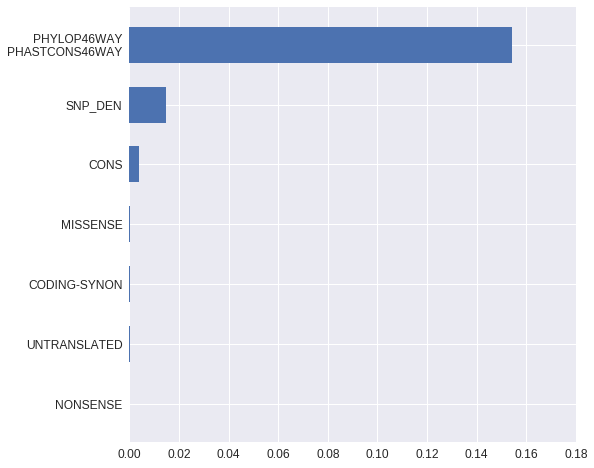

In [27]:
rfpimp.plot_importances(I.iloc[:7], label_fontsize=12, scalefig=(2,2), figsize=(8,8), tickstep=1, save="/home/marlan/Desktop/genomic_importance_cluster.pdf")

In [55]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rf.predict(X_test))))

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


              precision    recall  f1-score   support

     Disease       0.69      0.64      0.67      5877
Polymorphism       0.83      0.87      0.85     12400

 avg / total       0.79      0.79      0.79     18277



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


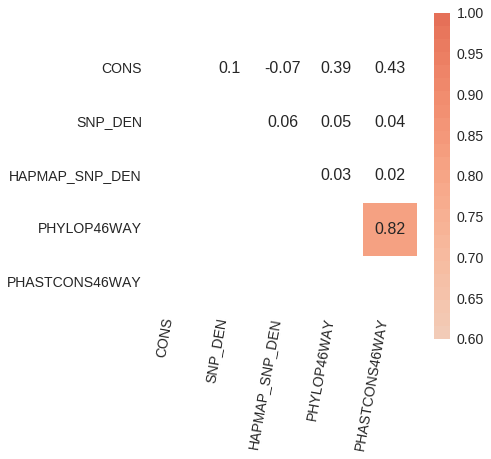

In [25]:
%load_ext autoreload
%autoreload 2
import rfpimp
rfpimp.plot_corr_heatmap(X[cont_vars], figsize=(6,6), label_fontsize=14, 
                         value_fontsize=16, save="/home/marlan/Desktop/genomic_corr.pdf")

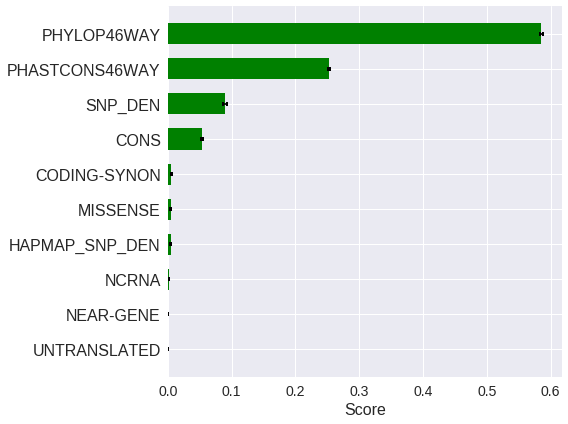

In [11]:
cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=14)
plt.tight_layout()

# plt.savefig("/home/marlan/Desktop/importances_genomic.pdf", bbox_inches='tight', pad_inches=0.1)


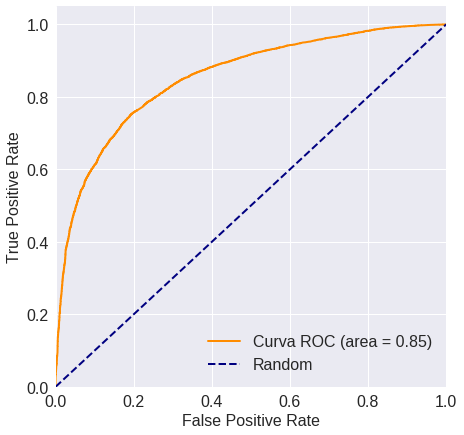

In [12]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/genomic/auc_rf.csv", index=False)

plt.figure(figsize=(7,7))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

plt.savefig("/home/marlan/Desktop/auc_genomic.pdf", bbox_inches='tight', pad_inches=0.1)

In [20]:
### Confidence Interval for AUC

import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

y_pred = rf.predict_proba(X_test)[:, 1]
y_true = y_test

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 10000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.853
Bootstrap #1 ROC area: 0.857
Bootstrap #2 ROC area: 0.851
Bootstrap #3 ROC area: 0.856
Bootstrap #4 ROC area: 0.857
Bootstrap #5 ROC area: 0.853
Bootstrap #6 ROC area: 0.851
Bootstrap #7 ROC area: 0.854
Bootstrap #8 ROC area: 0.854
Bootstrap #9 ROC area: 0.856
Bootstrap #10 ROC area: 0.850
Bootstrap #11 ROC area: 0.852
Bootstrap #12 ROC area: 0.855
Bootstrap #13 ROC area: 0.852
Bootstrap #14 ROC area: 0.852
Bootstrap #15 ROC area: 0.855
Bootstrap #16 ROC area: 0.855
Bootstrap #17 ROC area: 0.855
Bootstrap #18 ROC area: 0.855
Bootstrap #19 ROC area: 0.851
Bootstrap #20 ROC area: 0.854
Bootstrap #21 ROC area: 0.850
Bootstrap #22 ROC area: 0.853
Bootstrap #23 ROC area: 0.855
Bootstrap #24 ROC area: 0.856
Bootstrap #25 ROC area: 0.852
Bootstrap #26 ROC area: 0.855
Bootstrap #27 ROC area: 0.854
Bootstrap #28 ROC area: 0.855
Bootstrap #29 ROC area: 0.854
Bootstrap #30 ROC area: 0.854
Bootstrap #31 ROC area: 0.859
Bootstrap #32 ROC area: 0.851
Bootstrap #33 ROC area: 

/home/marlan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 18276 + 1) instead


Bootstrap #40 ROC area: 0.854
Bootstrap #41 ROC area: 0.858
Bootstrap #42 ROC area: 0.854
Bootstrap #43 ROC area: 0.854
Bootstrap #44 ROC area: 0.853
Bootstrap #45 ROC area: 0.854
Bootstrap #46 ROC area: 0.853
Bootstrap #47 ROC area: 0.853
Bootstrap #48 ROC area: 0.853
Bootstrap #49 ROC area: 0.856
Bootstrap #50 ROC area: 0.850
Bootstrap #51 ROC area: 0.852
Bootstrap #52 ROC area: 0.851
Bootstrap #53 ROC area: 0.850
Bootstrap #54 ROC area: 0.852
Bootstrap #55 ROC area: 0.851
Bootstrap #56 ROC area: 0.855
Bootstrap #57 ROC area: 0.850
Bootstrap #58 ROC area: 0.857
Bootstrap #59 ROC area: 0.854
Bootstrap #60 ROC area: 0.854
Bootstrap #61 ROC area: 0.858
Bootstrap #62 ROC area: 0.853
Bootstrap #63 ROC area: 0.854
Bootstrap #64 ROC area: 0.858
Bootstrap #65 ROC area: 0.856
Bootstrap #66 ROC area: 0.853
Bootstrap #67 ROC area: 0.858
Bootstrap #68 ROC area: 0.849
Bootstrap #69 ROC area: 0.854
Bootstrap #70 ROC area: 0.848
Bootstrap #71 ROC area: 0.857
Bootstrap #72 ROC area: 0.850
Bootstrap 

Bootstrap #331 ROC area: 0.852
Bootstrap #332 ROC area: 0.857
Bootstrap #333 ROC area: 0.854
Bootstrap #334 ROC area: 0.855
Bootstrap #335 ROC area: 0.853
Bootstrap #336 ROC area: 0.856
Bootstrap #337 ROC area: 0.851
Bootstrap #338 ROC area: 0.846
Bootstrap #339 ROC area: 0.845
Bootstrap #340 ROC area: 0.854
Bootstrap #341 ROC area: 0.850
Bootstrap #342 ROC area: 0.855
Bootstrap #343 ROC area: 0.850
Bootstrap #344 ROC area: 0.850
Bootstrap #345 ROC area: 0.852
Bootstrap #346 ROC area: 0.853
Bootstrap #347 ROC area: 0.857
Bootstrap #348 ROC area: 0.854
Bootstrap #349 ROC area: 0.849
Bootstrap #350 ROC area: 0.851
Bootstrap #351 ROC area: 0.854
Bootstrap #352 ROC area: 0.855
Bootstrap #353 ROC area: 0.853
Bootstrap #354 ROC area: 0.852
Bootstrap #355 ROC area: 0.855
Bootstrap #356 ROC area: 0.853
Bootstrap #357 ROC area: 0.855
Bootstrap #358 ROC area: 0.851
Bootstrap #359 ROC area: 0.856
Bootstrap #360 ROC area: 0.853
Bootstrap #361 ROC area: 0.850
Bootstrap #362 ROC area: 0.847
Bootstra

Bootstrap #607 ROC area: 0.855
Bootstrap #608 ROC area: 0.856
Bootstrap #609 ROC area: 0.853
Bootstrap #610 ROC area: 0.851
Bootstrap #611 ROC area: 0.854
Bootstrap #612 ROC area: 0.854
Bootstrap #613 ROC area: 0.854
Bootstrap #614 ROC area: 0.854
Bootstrap #615 ROC area: 0.855
Bootstrap #616 ROC area: 0.850
Bootstrap #617 ROC area: 0.852
Bootstrap #618 ROC area: 0.858
Bootstrap #619 ROC area: 0.855
Bootstrap #620 ROC area: 0.853
Bootstrap #621 ROC area: 0.856
Bootstrap #622 ROC area: 0.854
Bootstrap #623 ROC area: 0.856
Bootstrap #624 ROC area: 0.852
Bootstrap #625 ROC area: 0.856
Bootstrap #626 ROC area: 0.849
Bootstrap #627 ROC area: 0.853
Bootstrap #628 ROC area: 0.860
Bootstrap #629 ROC area: 0.859
Bootstrap #630 ROC area: 0.851
Bootstrap #631 ROC area: 0.852
Bootstrap #632 ROC area: 0.853
Bootstrap #633 ROC area: 0.850
Bootstrap #634 ROC area: 0.852
Bootstrap #635 ROC area: 0.854
Bootstrap #636 ROC area: 0.854
Bootstrap #637 ROC area: 0.851
Bootstrap #638 ROC area: 0.852
Bootstra

Bootstrap #883 ROC area: 0.859
Bootstrap #884 ROC area: 0.848
Bootstrap #885 ROC area: 0.856
Bootstrap #886 ROC area: 0.855
Bootstrap #887 ROC area: 0.856
Bootstrap #888 ROC area: 0.855
Bootstrap #889 ROC area: 0.853
Bootstrap #890 ROC area: 0.852
Bootstrap #891 ROC area: 0.858
Bootstrap #892 ROC area: 0.856
Bootstrap #893 ROC area: 0.855
Bootstrap #894 ROC area: 0.855
Bootstrap #895 ROC area: 0.855
Bootstrap #896 ROC area: 0.851
Bootstrap #897 ROC area: 0.854
Bootstrap #898 ROC area: 0.856
Bootstrap #899 ROC area: 0.854
Bootstrap #900 ROC area: 0.852
Bootstrap #901 ROC area: 0.853
Bootstrap #902 ROC area: 0.853
Bootstrap #903 ROC area: 0.855
Bootstrap #904 ROC area: 0.855
Bootstrap #905 ROC area: 0.853
Bootstrap #906 ROC area: 0.851
Bootstrap #907 ROC area: 0.855
Bootstrap #908 ROC area: 0.859
Bootstrap #909 ROC area: 0.851
Bootstrap #910 ROC area: 0.855
Bootstrap #911 ROC area: 0.854
Bootstrap #912 ROC area: 0.856
Bootstrap #913 ROC area: 0.853
Bootstrap #914 ROC area: 0.854
Bootstra

Bootstrap #1160 ROC area: 0.852
Bootstrap #1161 ROC area: 0.857
Bootstrap #1162 ROC area: 0.851
Bootstrap #1163 ROC area: 0.852
Bootstrap #1164 ROC area: 0.851
Bootstrap #1165 ROC area: 0.852
Bootstrap #1166 ROC area: 0.855
Bootstrap #1167 ROC area: 0.852
Bootstrap #1168 ROC area: 0.851
Bootstrap #1169 ROC area: 0.855
Bootstrap #1170 ROC area: 0.848
Bootstrap #1171 ROC area: 0.850
Bootstrap #1172 ROC area: 0.851
Bootstrap #1173 ROC area: 0.855
Bootstrap #1174 ROC area: 0.853
Bootstrap #1175 ROC area: 0.848
Bootstrap #1176 ROC area: 0.854
Bootstrap #1177 ROC area: 0.849
Bootstrap #1178 ROC area: 0.855
Bootstrap #1179 ROC area: 0.860
Bootstrap #1180 ROC area: 0.858
Bootstrap #1181 ROC area: 0.853
Bootstrap #1182 ROC area: 0.850
Bootstrap #1183 ROC area: 0.856
Bootstrap #1184 ROC area: 0.851
Bootstrap #1185 ROC area: 0.850
Bootstrap #1186 ROC area: 0.857
Bootstrap #1187 ROC area: 0.848
Bootstrap #1188 ROC area: 0.855
Bootstrap #1189 ROC area: 0.851
Bootstrap #1190 ROC area: 0.853
Bootstra

Bootstrap #1442 ROC area: 0.851
Bootstrap #1443 ROC area: 0.849
Bootstrap #1444 ROC area: 0.853
Bootstrap #1445 ROC area: 0.853
Bootstrap #1446 ROC area: 0.854
Bootstrap #1447 ROC area: 0.855
Bootstrap #1448 ROC area: 0.856
Bootstrap #1449 ROC area: 0.856
Bootstrap #1450 ROC area: 0.853
Bootstrap #1451 ROC area: 0.856
Bootstrap #1452 ROC area: 0.852
Bootstrap #1453 ROC area: 0.851
Bootstrap #1454 ROC area: 0.854
Bootstrap #1455 ROC area: 0.856
Bootstrap #1456 ROC area: 0.853
Bootstrap #1457 ROC area: 0.855
Bootstrap #1458 ROC area: 0.855
Bootstrap #1459 ROC area: 0.852
Bootstrap #1460 ROC area: 0.853
Bootstrap #1461 ROC area: 0.849
Bootstrap #1462 ROC area: 0.851
Bootstrap #1463 ROC area: 0.855
Bootstrap #1464 ROC area: 0.851
Bootstrap #1465 ROC area: 0.855
Bootstrap #1466 ROC area: 0.849
Bootstrap #1467 ROC area: 0.851
Bootstrap #1468 ROC area: 0.852
Bootstrap #1469 ROC area: 0.855
Bootstrap #1470 ROC area: 0.857
Bootstrap #1471 ROC area: 0.853
Bootstrap #1472 ROC area: 0.855
Bootstra

Bootstrap #1709 ROC area: 0.852
Bootstrap #1710 ROC area: 0.847
Bootstrap #1711 ROC area: 0.846
Bootstrap #1712 ROC area: 0.849
Bootstrap #1713 ROC area: 0.855
Bootstrap #1714 ROC area: 0.852
Bootstrap #1715 ROC area: 0.852
Bootstrap #1716 ROC area: 0.854
Bootstrap #1717 ROC area: 0.850
Bootstrap #1718 ROC area: 0.856
Bootstrap #1719 ROC area: 0.858
Bootstrap #1720 ROC area: 0.853
Bootstrap #1721 ROC area: 0.853
Bootstrap #1722 ROC area: 0.852
Bootstrap #1723 ROC area: 0.851
Bootstrap #1724 ROC area: 0.852
Bootstrap #1725 ROC area: 0.853
Bootstrap #1726 ROC area: 0.853
Bootstrap #1727 ROC area: 0.854
Bootstrap #1728 ROC area: 0.850
Bootstrap #1729 ROC area: 0.851
Bootstrap #1730 ROC area: 0.853
Bootstrap #1731 ROC area: 0.853
Bootstrap #1732 ROC area: 0.854
Bootstrap #1733 ROC area: 0.855
Bootstrap #1734 ROC area: 0.857
Bootstrap #1735 ROC area: 0.850
Bootstrap #1736 ROC area: 0.851
Bootstrap #1737 ROC area: 0.852
Bootstrap #1738 ROC area: 0.854
Bootstrap #1739 ROC area: 0.858
Bootstra

Bootstrap #1980 ROC area: 0.850
Bootstrap #1981 ROC area: 0.855
Bootstrap #1982 ROC area: 0.853
Bootstrap #1983 ROC area: 0.855
Bootstrap #1984 ROC area: 0.852
Bootstrap #1985 ROC area: 0.854
Bootstrap #1986 ROC area: 0.851
Bootstrap #1987 ROC area: 0.853
Bootstrap #1988 ROC area: 0.848
Bootstrap #1989 ROC area: 0.855
Bootstrap #1990 ROC area: 0.856
Bootstrap #1991 ROC area: 0.851
Bootstrap #1992 ROC area: 0.856
Bootstrap #1993 ROC area: 0.861
Bootstrap #1994 ROC area: 0.850
Bootstrap #1995 ROC area: 0.856
Bootstrap #1996 ROC area: 0.857
Bootstrap #1997 ROC area: 0.860
Bootstrap #1998 ROC area: 0.855
Bootstrap #1999 ROC area: 0.849
Bootstrap #2000 ROC area: 0.851
Bootstrap #2001 ROC area: 0.854
Bootstrap #2002 ROC area: 0.854
Bootstrap #2003 ROC area: 0.853
Bootstrap #2004 ROC area: 0.852
Bootstrap #2005 ROC area: 0.856
Bootstrap #2006 ROC area: 0.853
Bootstrap #2007 ROC area: 0.852
Bootstrap #2008 ROC area: 0.854
Bootstrap #2009 ROC area: 0.852
Bootstrap #2010 ROC area: 0.848
Bootstra

Bootstrap #2253 ROC area: 0.851
Bootstrap #2254 ROC area: 0.856
Bootstrap #2255 ROC area: 0.857
Bootstrap #2256 ROC area: 0.851
Bootstrap #2257 ROC area: 0.853
Bootstrap #2258 ROC area: 0.851
Bootstrap #2259 ROC area: 0.854
Bootstrap #2260 ROC area: 0.856
Bootstrap #2261 ROC area: 0.853
Bootstrap #2262 ROC area: 0.851
Bootstrap #2263 ROC area: 0.855
Bootstrap #2264 ROC area: 0.855
Bootstrap #2265 ROC area: 0.849
Bootstrap #2266 ROC area: 0.857
Bootstrap #2267 ROC area: 0.854
Bootstrap #2268 ROC area: 0.851
Bootstrap #2269 ROC area: 0.857
Bootstrap #2270 ROC area: 0.860
Bootstrap #2271 ROC area: 0.852
Bootstrap #2272 ROC area: 0.852
Bootstrap #2273 ROC area: 0.851
Bootstrap #2274 ROC area: 0.855
Bootstrap #2275 ROC area: 0.855
Bootstrap #2276 ROC area: 0.855
Bootstrap #2277 ROC area: 0.851
Bootstrap #2278 ROC area: 0.854
Bootstrap #2279 ROC area: 0.853
Bootstrap #2280 ROC area: 0.857
Bootstrap #2281 ROC area: 0.860
Bootstrap #2282 ROC area: 0.854
Bootstrap #2283 ROC area: 0.857
Bootstra

Bootstrap #2529 ROC area: 0.858
Bootstrap #2530 ROC area: 0.849
Bootstrap #2531 ROC area: 0.853
Bootstrap #2532 ROC area: 0.848
Bootstrap #2533 ROC area: 0.854
Bootstrap #2534 ROC area: 0.853
Bootstrap #2535 ROC area: 0.855
Bootstrap #2536 ROC area: 0.854
Bootstrap #2537 ROC area: 0.855
Bootstrap #2538 ROC area: 0.853
Bootstrap #2539 ROC area: 0.853
Bootstrap #2540 ROC area: 0.858
Bootstrap #2541 ROC area: 0.857
Bootstrap #2542 ROC area: 0.854
Bootstrap #2543 ROC area: 0.852
Bootstrap #2544 ROC area: 0.853
Bootstrap #2545 ROC area: 0.854
Bootstrap #2546 ROC area: 0.855
Bootstrap #2547 ROC area: 0.852
Bootstrap #2548 ROC area: 0.853
Bootstrap #2549 ROC area: 0.853
Bootstrap #2550 ROC area: 0.856
Bootstrap #2551 ROC area: 0.853
Bootstrap #2552 ROC area: 0.854
Bootstrap #2553 ROC area: 0.855
Bootstrap #2554 ROC area: 0.855
Bootstrap #2555 ROC area: 0.854
Bootstrap #2556 ROC area: 0.859
Bootstrap #2557 ROC area: 0.853
Bootstrap #2558 ROC area: 0.853
Bootstrap #2559 ROC area: 0.854
Bootstra

Bootstrap #2797 ROC area: 0.850
Bootstrap #2798 ROC area: 0.850
Bootstrap #2799 ROC area: 0.853
Bootstrap #2800 ROC area: 0.853
Bootstrap #2801 ROC area: 0.855
Bootstrap #2802 ROC area: 0.849
Bootstrap #2803 ROC area: 0.851
Bootstrap #2804 ROC area: 0.855
Bootstrap #2805 ROC area: 0.850
Bootstrap #2806 ROC area: 0.851
Bootstrap #2807 ROC area: 0.855
Bootstrap #2808 ROC area: 0.851
Bootstrap #2809 ROC area: 0.854
Bootstrap #2810 ROC area: 0.854
Bootstrap #2811 ROC area: 0.857
Bootstrap #2812 ROC area: 0.850
Bootstrap #2813 ROC area: 0.852
Bootstrap #2814 ROC area: 0.850
Bootstrap #2815 ROC area: 0.854
Bootstrap #2816 ROC area: 0.855
Bootstrap #2817 ROC area: 0.857
Bootstrap #2818 ROC area: 0.857
Bootstrap #2819 ROC area: 0.855
Bootstrap #2820 ROC area: 0.855
Bootstrap #2821 ROC area: 0.855
Bootstrap #2822 ROC area: 0.850
Bootstrap #2823 ROC area: 0.849
Bootstrap #2824 ROC area: 0.854
Bootstrap #2825 ROC area: 0.853
Bootstrap #2826 ROC area: 0.850
Bootstrap #2827 ROC area: 0.857
Bootstra

Bootstrap #3064 ROC area: 0.859
Bootstrap #3065 ROC area: 0.848
Bootstrap #3066 ROC area: 0.846
Bootstrap #3067 ROC area: 0.851
Bootstrap #3068 ROC area: 0.851
Bootstrap #3069 ROC area: 0.852
Bootstrap #3070 ROC area: 0.856
Bootstrap #3071 ROC area: 0.852
Bootstrap #3072 ROC area: 0.852
Bootstrap #3073 ROC area: 0.854
Bootstrap #3074 ROC area: 0.853
Bootstrap #3075 ROC area: 0.851
Bootstrap #3076 ROC area: 0.853
Bootstrap #3077 ROC area: 0.854
Bootstrap #3078 ROC area: 0.852
Bootstrap #3079 ROC area: 0.858
Bootstrap #3080 ROC area: 0.851
Bootstrap #3081 ROC area: 0.855
Bootstrap #3082 ROC area: 0.853
Bootstrap #3083 ROC area: 0.854
Bootstrap #3084 ROC area: 0.858
Bootstrap #3085 ROC area: 0.850
Bootstrap #3086 ROC area: 0.850
Bootstrap #3087 ROC area: 0.851
Bootstrap #3088 ROC area: 0.854
Bootstrap #3089 ROC area: 0.851
Bootstrap #3090 ROC area: 0.850
Bootstrap #3091 ROC area: 0.855
Bootstrap #3092 ROC area: 0.853
Bootstrap #3093 ROC area: 0.850
Bootstrap #3094 ROC area: 0.853
Bootstra

Bootstrap #3324 ROC area: 0.854
Bootstrap #3325 ROC area: 0.852
Bootstrap #3326 ROC area: 0.851
Bootstrap #3327 ROC area: 0.856
Bootstrap #3328 ROC area: 0.859
Bootstrap #3329 ROC area: 0.858
Bootstrap #3330 ROC area: 0.853
Bootstrap #3331 ROC area: 0.855
Bootstrap #3332 ROC area: 0.853
Bootstrap #3333 ROC area: 0.853
Bootstrap #3334 ROC area: 0.857
Bootstrap #3335 ROC area: 0.852
Bootstrap #3336 ROC area: 0.852
Bootstrap #3337 ROC area: 0.855
Bootstrap #3338 ROC area: 0.848
Bootstrap #3339 ROC area: 0.854
Bootstrap #3340 ROC area: 0.852
Bootstrap #3341 ROC area: 0.857
Bootstrap #3342 ROC area: 0.849
Bootstrap #3343 ROC area: 0.854
Bootstrap #3344 ROC area: 0.855
Bootstrap #3345 ROC area: 0.857
Bootstrap #3346 ROC area: 0.855
Bootstrap #3347 ROC area: 0.859
Bootstrap #3348 ROC area: 0.849
Bootstrap #3349 ROC area: 0.857
Bootstrap #3350 ROC area: 0.856
Bootstrap #3351 ROC area: 0.854
Bootstrap #3352 ROC area: 0.850
Bootstrap #3353 ROC area: 0.855
Bootstrap #3354 ROC area: 0.851
Bootstra

Bootstrap #3595 ROC area: 0.858
Bootstrap #3596 ROC area: 0.854
Bootstrap #3597 ROC area: 0.849
Bootstrap #3598 ROC area: 0.859
Bootstrap #3599 ROC area: 0.856
Bootstrap #3600 ROC area: 0.851
Bootstrap #3601 ROC area: 0.853
Bootstrap #3602 ROC area: 0.854
Bootstrap #3603 ROC area: 0.850
Bootstrap #3604 ROC area: 0.853
Bootstrap #3605 ROC area: 0.855
Bootstrap #3606 ROC area: 0.847
Bootstrap #3607 ROC area: 0.852
Bootstrap #3608 ROC area: 0.856
Bootstrap #3609 ROC area: 0.851
Bootstrap #3610 ROC area: 0.853
Bootstrap #3611 ROC area: 0.851
Bootstrap #3612 ROC area: 0.850
Bootstrap #3613 ROC area: 0.851
Bootstrap #3614 ROC area: 0.853
Bootstrap #3615 ROC area: 0.855
Bootstrap #3616 ROC area: 0.859
Bootstrap #3617 ROC area: 0.853
Bootstrap #3618 ROC area: 0.850
Bootstrap #3619 ROC area: 0.853
Bootstrap #3620 ROC area: 0.858
Bootstrap #3621 ROC area: 0.852
Bootstrap #3622 ROC area: 0.852
Bootstrap #3623 ROC area: 0.846
Bootstrap #3624 ROC area: 0.854
Bootstrap #3625 ROC area: 0.857
Bootstra

Bootstrap #3861 ROC area: 0.855
Bootstrap #3862 ROC area: 0.851
Bootstrap #3863 ROC area: 0.857
Bootstrap #3864 ROC area: 0.852
Bootstrap #3865 ROC area: 0.855
Bootstrap #3866 ROC area: 0.852
Bootstrap #3867 ROC area: 0.860
Bootstrap #3868 ROC area: 0.849
Bootstrap #3869 ROC area: 0.851
Bootstrap #3870 ROC area: 0.848
Bootstrap #3871 ROC area: 0.855
Bootstrap #3872 ROC area: 0.852
Bootstrap #3873 ROC area: 0.852
Bootstrap #3874 ROC area: 0.855
Bootstrap #3875 ROC area: 0.855
Bootstrap #3876 ROC area: 0.852
Bootstrap #3877 ROC area: 0.854
Bootstrap #3878 ROC area: 0.852
Bootstrap #3879 ROC area: 0.854
Bootstrap #3880 ROC area: 0.854
Bootstrap #3881 ROC area: 0.853
Bootstrap #3882 ROC area: 0.860
Bootstrap #3883 ROC area: 0.855
Bootstrap #3884 ROC area: 0.856
Bootstrap #3885 ROC area: 0.852
Bootstrap #3886 ROC area: 0.853
Bootstrap #3887 ROC area: 0.853
Bootstrap #3888 ROC area: 0.852
Bootstrap #3889 ROC area: 0.855
Bootstrap #3890 ROC area: 0.854
Bootstrap #3891 ROC area: 0.855
Bootstra

Bootstrap #4137 ROC area: 0.851
Bootstrap #4138 ROC area: 0.849
Bootstrap #4139 ROC area: 0.851
Bootstrap #4140 ROC area: 0.858
Bootstrap #4141 ROC area: 0.855
Bootstrap #4142 ROC area: 0.854
Bootstrap #4143 ROC area: 0.852
Bootstrap #4144 ROC area: 0.851
Bootstrap #4145 ROC area: 0.856
Bootstrap #4146 ROC area: 0.850
Bootstrap #4147 ROC area: 0.855
Bootstrap #4148 ROC area: 0.853
Bootstrap #4149 ROC area: 0.856
Bootstrap #4150 ROC area: 0.856
Bootstrap #4151 ROC area: 0.852
Bootstrap #4152 ROC area: 0.855
Bootstrap #4153 ROC area: 0.855
Bootstrap #4154 ROC area: 0.846
Bootstrap #4155 ROC area: 0.852
Bootstrap #4156 ROC area: 0.856
Bootstrap #4157 ROC area: 0.852
Bootstrap #4158 ROC area: 0.859
Bootstrap #4159 ROC area: 0.853
Bootstrap #4160 ROC area: 0.852
Bootstrap #4161 ROC area: 0.853
Bootstrap #4162 ROC area: 0.852
Bootstrap #4163 ROC area: 0.853
Bootstrap #4164 ROC area: 0.853
Bootstrap #4165 ROC area: 0.851
Bootstrap #4166 ROC area: 0.850
Bootstrap #4167 ROC area: 0.855
Bootstra

Bootstrap #4409 ROC area: 0.850
Bootstrap #4410 ROC area: 0.851
Bootstrap #4411 ROC area: 0.851
Bootstrap #4412 ROC area: 0.855
Bootstrap #4413 ROC area: 0.848
Bootstrap #4414 ROC area: 0.852
Bootstrap #4415 ROC area: 0.852
Bootstrap #4416 ROC area: 0.853
Bootstrap #4417 ROC area: 0.853
Bootstrap #4418 ROC area: 0.849
Bootstrap #4419 ROC area: 0.856
Bootstrap #4420 ROC area: 0.852
Bootstrap #4421 ROC area: 0.857
Bootstrap #4422 ROC area: 0.855
Bootstrap #4423 ROC area: 0.848
Bootstrap #4424 ROC area: 0.847
Bootstrap #4425 ROC area: 0.853
Bootstrap #4426 ROC area: 0.853
Bootstrap #4427 ROC area: 0.853
Bootstrap #4428 ROC area: 0.857
Bootstrap #4429 ROC area: 0.852
Bootstrap #4430 ROC area: 0.848
Bootstrap #4431 ROC area: 0.854
Bootstrap #4432 ROC area: 0.850
Bootstrap #4433 ROC area: 0.849
Bootstrap #4434 ROC area: 0.852
Bootstrap #4435 ROC area: 0.856
Bootstrap #4436 ROC area: 0.853
Bootstrap #4437 ROC area: 0.848
Bootstrap #4438 ROC area: 0.853
Bootstrap #4439 ROC area: 0.860
Bootstra

Bootstrap #4669 ROC area: 0.845
Bootstrap #4670 ROC area: 0.851
Bootstrap #4671 ROC area: 0.851
Bootstrap #4672 ROC area: 0.850
Bootstrap #4673 ROC area: 0.857
Bootstrap #4674 ROC area: 0.849
Bootstrap #4675 ROC area: 0.849
Bootstrap #4676 ROC area: 0.852
Bootstrap #4677 ROC area: 0.847
Bootstrap #4678 ROC area: 0.851
Bootstrap #4679 ROC area: 0.849
Bootstrap #4680 ROC area: 0.852
Bootstrap #4681 ROC area: 0.854
Bootstrap #4682 ROC area: 0.857
Bootstrap #4683 ROC area: 0.846
Bootstrap #4684 ROC area: 0.848
Bootstrap #4685 ROC area: 0.848
Bootstrap #4686 ROC area: 0.857
Bootstrap #4687 ROC area: 0.853
Bootstrap #4688 ROC area: 0.854
Bootstrap #4689 ROC area: 0.853
Bootstrap #4690 ROC area: 0.858
Bootstrap #4691 ROC area: 0.849
Bootstrap #4692 ROC area: 0.854
Bootstrap #4693 ROC area: 0.856
Bootstrap #4694 ROC area: 0.857
Bootstrap #4695 ROC area: 0.853
Bootstrap #4696 ROC area: 0.859
Bootstrap #4697 ROC area: 0.858
Bootstrap #4698 ROC area: 0.855
Bootstrap #4699 ROC area: 0.853
Bootstra

Bootstrap #4946 ROC area: 0.854
Bootstrap #4947 ROC area: 0.854
Bootstrap #4948 ROC area: 0.861
Bootstrap #4949 ROC area: 0.850
Bootstrap #4950 ROC area: 0.852
Bootstrap #4951 ROC area: 0.852
Bootstrap #4952 ROC area: 0.855
Bootstrap #4953 ROC area: 0.855
Bootstrap #4954 ROC area: 0.858
Bootstrap #4955 ROC area: 0.854
Bootstrap #4956 ROC area: 0.852
Bootstrap #4957 ROC area: 0.852
Bootstrap #4958 ROC area: 0.850
Bootstrap #4959 ROC area: 0.853
Bootstrap #4960 ROC area: 0.852
Bootstrap #4961 ROC area: 0.858
Bootstrap #4962 ROC area: 0.851
Bootstrap #4963 ROC area: 0.855
Bootstrap #4964 ROC area: 0.854
Bootstrap #4965 ROC area: 0.853
Bootstrap #4966 ROC area: 0.855
Bootstrap #4967 ROC area: 0.851
Bootstrap #4968 ROC area: 0.853
Bootstrap #4969 ROC area: 0.854
Bootstrap #4970 ROC area: 0.850
Bootstrap #4971 ROC area: 0.854
Bootstrap #4972 ROC area: 0.850
Bootstrap #4973 ROC area: 0.854
Bootstrap #4974 ROC area: 0.855
Bootstrap #4975 ROC area: 0.854
Bootstrap #4976 ROC area: 0.855
Bootstra

Bootstrap #5225 ROC area: 0.851
Bootstrap #5226 ROC area: 0.858
Bootstrap #5227 ROC area: 0.851
Bootstrap #5228 ROC area: 0.852
Bootstrap #5229 ROC area: 0.851
Bootstrap #5230 ROC area: 0.852
Bootstrap #5231 ROC area: 0.849
Bootstrap #5232 ROC area: 0.856
Bootstrap #5233 ROC area: 0.851
Bootstrap #5234 ROC area: 0.857
Bootstrap #5235 ROC area: 0.850
Bootstrap #5236 ROC area: 0.855
Bootstrap #5237 ROC area: 0.848
Bootstrap #5238 ROC area: 0.853
Bootstrap #5239 ROC area: 0.853
Bootstrap #5240 ROC area: 0.861
Bootstrap #5241 ROC area: 0.855
Bootstrap #5242 ROC area: 0.846
Bootstrap #5243 ROC area: 0.852
Bootstrap #5244 ROC area: 0.855
Bootstrap #5245 ROC area: 0.851
Bootstrap #5246 ROC area: 0.857
Bootstrap #5247 ROC area: 0.855
Bootstrap #5248 ROC area: 0.852
Bootstrap #5249 ROC area: 0.853
Bootstrap #5250 ROC area: 0.861
Bootstrap #5251 ROC area: 0.849
Bootstrap #5252 ROC area: 0.860
Bootstrap #5253 ROC area: 0.852
Bootstrap #5254 ROC area: 0.857
Bootstrap #5255 ROC area: 0.856
Bootstra

Bootstrap #5504 ROC area: 0.851
Bootstrap #5505 ROC area: 0.852
Bootstrap #5506 ROC area: 0.850
Bootstrap #5507 ROC area: 0.855
Bootstrap #5508 ROC area: 0.854
Bootstrap #5509 ROC area: 0.857
Bootstrap #5510 ROC area: 0.849
Bootstrap #5511 ROC area: 0.853
Bootstrap #5512 ROC area: 0.860
Bootstrap #5513 ROC area: 0.855
Bootstrap #5514 ROC area: 0.854
Bootstrap #5515 ROC area: 0.849
Bootstrap #5516 ROC area: 0.853
Bootstrap #5517 ROC area: 0.858
Bootstrap #5518 ROC area: 0.855
Bootstrap #5519 ROC area: 0.853
Bootstrap #5520 ROC area: 0.852
Bootstrap #5521 ROC area: 0.852
Bootstrap #5522 ROC area: 0.853
Bootstrap #5523 ROC area: 0.854
Bootstrap #5524 ROC area: 0.856
Bootstrap #5525 ROC area: 0.855
Bootstrap #5526 ROC area: 0.855
Bootstrap #5527 ROC area: 0.853
Bootstrap #5528 ROC area: 0.851
Bootstrap #5529 ROC area: 0.851
Bootstrap #5530 ROC area: 0.853
Bootstrap #5531 ROC area: 0.852
Bootstrap #5532 ROC area: 0.853
Bootstrap #5533 ROC area: 0.861
Bootstrap #5534 ROC area: 0.851
Bootstra

Bootstrap #5782 ROC area: 0.856
Bootstrap #5783 ROC area: 0.850
Bootstrap #5784 ROC area: 0.855
Bootstrap #5785 ROC area: 0.853
Bootstrap #5786 ROC area: 0.852
Bootstrap #5787 ROC area: 0.852
Bootstrap #5788 ROC area: 0.851
Bootstrap #5789 ROC area: 0.851
Bootstrap #5790 ROC area: 0.857
Bootstrap #5791 ROC area: 0.850
Bootstrap #5792 ROC area: 0.854
Bootstrap #5793 ROC area: 0.848
Bootstrap #5794 ROC area: 0.853
Bootstrap #5795 ROC area: 0.854
Bootstrap #5796 ROC area: 0.852
Bootstrap #5797 ROC area: 0.853
Bootstrap #5798 ROC area: 0.853
Bootstrap #5799 ROC area: 0.853
Bootstrap #5800 ROC area: 0.856
Bootstrap #5801 ROC area: 0.854
Bootstrap #5802 ROC area: 0.849
Bootstrap #5803 ROC area: 0.858
Bootstrap #5804 ROC area: 0.852
Bootstrap #5805 ROC area: 0.855
Bootstrap #5806 ROC area: 0.852
Bootstrap #5807 ROC area: 0.851
Bootstrap #5808 ROC area: 0.858
Bootstrap #5809 ROC area: 0.852
Bootstrap #5810 ROC area: 0.855
Bootstrap #5811 ROC area: 0.854
Bootstrap #5812 ROC area: 0.849
Bootstra

Bootstrap #6061 ROC area: 0.854
Bootstrap #6062 ROC area: 0.851
Bootstrap #6063 ROC area: 0.857
Bootstrap #6064 ROC area: 0.855
Bootstrap #6065 ROC area: 0.854
Bootstrap #6066 ROC area: 0.856
Bootstrap #6067 ROC area: 0.851
Bootstrap #6068 ROC area: 0.858
Bootstrap #6069 ROC area: 0.847
Bootstrap #6070 ROC area: 0.857
Bootstrap #6071 ROC area: 0.854
Bootstrap #6072 ROC area: 0.850
Bootstrap #6073 ROC area: 0.848
Bootstrap #6074 ROC area: 0.855
Bootstrap #6075 ROC area: 0.852
Bootstrap #6076 ROC area: 0.856
Bootstrap #6077 ROC area: 0.850
Bootstrap #6078 ROC area: 0.853
Bootstrap #6079 ROC area: 0.853
Bootstrap #6080 ROC area: 0.852
Bootstrap #6081 ROC area: 0.848
Bootstrap #6082 ROC area: 0.852
Bootstrap #6083 ROC area: 0.848
Bootstrap #6084 ROC area: 0.842
Bootstrap #6085 ROC area: 0.854
Bootstrap #6086 ROC area: 0.857
Bootstrap #6087 ROC area: 0.856
Bootstrap #6088 ROC area: 0.852
Bootstrap #6089 ROC area: 0.848
Bootstrap #6090 ROC area: 0.856
Bootstrap #6091 ROC area: 0.857
Bootstra

Bootstrap #6340 ROC area: 0.855
Bootstrap #6341 ROC area: 0.858
Bootstrap #6342 ROC area: 0.856
Bootstrap #6343 ROC area: 0.851
Bootstrap #6344 ROC area: 0.856
Bootstrap #6345 ROC area: 0.855
Bootstrap #6346 ROC area: 0.852
Bootstrap #6347 ROC area: 0.854
Bootstrap #6348 ROC area: 0.853
Bootstrap #6349 ROC area: 0.860
Bootstrap #6350 ROC area: 0.854
Bootstrap #6351 ROC area: 0.858
Bootstrap #6352 ROC area: 0.859
Bootstrap #6353 ROC area: 0.850
Bootstrap #6354 ROC area: 0.851
Bootstrap #6355 ROC area: 0.857
Bootstrap #6356 ROC area: 0.851
Bootstrap #6357 ROC area: 0.850
Bootstrap #6358 ROC area: 0.859
Bootstrap #6359 ROC area: 0.852
Bootstrap #6360 ROC area: 0.856
Bootstrap #6361 ROC area: 0.856
Bootstrap #6362 ROC area: 0.849
Bootstrap #6363 ROC area: 0.853
Bootstrap #6364 ROC area: 0.855
Bootstrap #6365 ROC area: 0.854
Bootstrap #6366 ROC area: 0.852
Bootstrap #6367 ROC area: 0.857
Bootstrap #6368 ROC area: 0.854
Bootstrap #6369 ROC area: 0.855
Bootstrap #6370 ROC area: 0.854
Bootstra

Bootstrap #6618 ROC area: 0.853
Bootstrap #6619 ROC area: 0.852
Bootstrap #6620 ROC area: 0.859
Bootstrap #6621 ROC area: 0.856
Bootstrap #6622 ROC area: 0.857
Bootstrap #6623 ROC area: 0.857
Bootstrap #6624 ROC area: 0.846
Bootstrap #6625 ROC area: 0.852
Bootstrap #6626 ROC area: 0.856
Bootstrap #6627 ROC area: 0.853
Bootstrap #6628 ROC area: 0.851
Bootstrap #6629 ROC area: 0.856
Bootstrap #6630 ROC area: 0.846
Bootstrap #6631 ROC area: 0.852
Bootstrap #6632 ROC area: 0.859
Bootstrap #6633 ROC area: 0.853
Bootstrap #6634 ROC area: 0.855
Bootstrap #6635 ROC area: 0.854
Bootstrap #6636 ROC area: 0.851
Bootstrap #6637 ROC area: 0.853
Bootstrap #6638 ROC area: 0.854
Bootstrap #6639 ROC area: 0.859
Bootstrap #6640 ROC area: 0.854
Bootstrap #6641 ROC area: 0.854
Bootstrap #6642 ROC area: 0.855
Bootstrap #6643 ROC area: 0.853
Bootstrap #6644 ROC area: 0.853
Bootstrap #6645 ROC area: 0.855
Bootstrap #6646 ROC area: 0.854
Bootstrap #6647 ROC area: 0.851
Bootstrap #6648 ROC area: 0.852
Bootstra

Bootstrap #6896 ROC area: 0.856
Bootstrap #6897 ROC area: 0.858
Bootstrap #6898 ROC area: 0.854
Bootstrap #6899 ROC area: 0.854
Bootstrap #6900 ROC area: 0.852
Bootstrap #6901 ROC area: 0.850
Bootstrap #6902 ROC area: 0.855
Bootstrap #6903 ROC area: 0.853
Bootstrap #6904 ROC area: 0.853
Bootstrap #6905 ROC area: 0.851
Bootstrap #6906 ROC area: 0.856
Bootstrap #6907 ROC area: 0.854
Bootstrap #6908 ROC area: 0.851
Bootstrap #6909 ROC area: 0.848
Bootstrap #6910 ROC area: 0.851
Bootstrap #6911 ROC area: 0.851
Bootstrap #6912 ROC area: 0.854
Bootstrap #6913 ROC area: 0.852
Bootstrap #6914 ROC area: 0.856
Bootstrap #6915 ROC area: 0.850
Bootstrap #6916 ROC area: 0.853
Bootstrap #6917 ROC area: 0.856
Bootstrap #6918 ROC area: 0.853
Bootstrap #6919 ROC area: 0.856
Bootstrap #6920 ROC area: 0.850
Bootstrap #6921 ROC area: 0.860
Bootstrap #6922 ROC area: 0.853
Bootstrap #6923 ROC area: 0.855
Bootstrap #6924 ROC area: 0.857
Bootstrap #6925 ROC area: 0.857
Bootstrap #6926 ROC area: 0.856
Bootstra

Bootstrap #7173 ROC area: 0.854
Bootstrap #7174 ROC area: 0.857
Bootstrap #7175 ROC area: 0.850
Bootstrap #7176 ROC area: 0.852
Bootstrap #7177 ROC area: 0.857
Bootstrap #7178 ROC area: 0.851
Bootstrap #7179 ROC area: 0.855
Bootstrap #7180 ROC area: 0.853
Bootstrap #7181 ROC area: 0.854
Bootstrap #7182 ROC area: 0.851
Bootstrap #7183 ROC area: 0.853
Bootstrap #7184 ROC area: 0.850
Bootstrap #7185 ROC area: 0.854
Bootstrap #7186 ROC area: 0.850
Bootstrap #7187 ROC area: 0.856
Bootstrap #7188 ROC area: 0.850
Bootstrap #7189 ROC area: 0.852
Bootstrap #7190 ROC area: 0.853
Bootstrap #7191 ROC area: 0.852
Bootstrap #7192 ROC area: 0.850
Bootstrap #7193 ROC area: 0.855
Bootstrap #7194 ROC area: 0.854
Bootstrap #7195 ROC area: 0.850
Bootstrap #7196 ROC area: 0.852
Bootstrap #7197 ROC area: 0.851
Bootstrap #7198 ROC area: 0.852
Bootstrap #7199 ROC area: 0.850
Bootstrap #7200 ROC area: 0.852
Bootstrap #7201 ROC area: 0.853
Bootstrap #7202 ROC area: 0.860
Bootstrap #7203 ROC area: 0.853
Bootstra

Bootstrap #7452 ROC area: 0.853
Bootstrap #7453 ROC area: 0.853
Bootstrap #7454 ROC area: 0.850
Bootstrap #7455 ROC area: 0.854
Bootstrap #7456 ROC area: 0.852
Bootstrap #7457 ROC area: 0.856
Bootstrap #7458 ROC area: 0.853
Bootstrap #7459 ROC area: 0.851
Bootstrap #7460 ROC area: 0.844
Bootstrap #7461 ROC area: 0.852
Bootstrap #7462 ROC area: 0.850
Bootstrap #7463 ROC area: 0.847
Bootstrap #7464 ROC area: 0.853
Bootstrap #7465 ROC area: 0.857
Bootstrap #7466 ROC area: 0.849
Bootstrap #7467 ROC area: 0.852
Bootstrap #7468 ROC area: 0.853
Bootstrap #7469 ROC area: 0.859
Bootstrap #7470 ROC area: 0.855
Bootstrap #7471 ROC area: 0.859
Bootstrap #7472 ROC area: 0.859
Bootstrap #7473 ROC area: 0.856
Bootstrap #7474 ROC area: 0.856
Bootstrap #7475 ROC area: 0.858
Bootstrap #7476 ROC area: 0.853
Bootstrap #7477 ROC area: 0.861
Bootstrap #7478 ROC area: 0.851
Bootstrap #7479 ROC area: 0.853
Bootstrap #7480 ROC area: 0.848
Bootstrap #7481 ROC area: 0.849
Bootstrap #7482 ROC area: 0.854
Bootstra

Bootstrap #7728 ROC area: 0.855
Bootstrap #7729 ROC area: 0.857
Bootstrap #7730 ROC area: 0.854
Bootstrap #7731 ROC area: 0.856
Bootstrap #7732 ROC area: 0.853
Bootstrap #7733 ROC area: 0.850
Bootstrap #7734 ROC area: 0.859
Bootstrap #7735 ROC area: 0.855
Bootstrap #7736 ROC area: 0.855
Bootstrap #7737 ROC area: 0.852
Bootstrap #7738 ROC area: 0.849
Bootstrap #7739 ROC area: 0.857
Bootstrap #7740 ROC area: 0.860
Bootstrap #7741 ROC area: 0.858
Bootstrap #7742 ROC area: 0.857
Bootstrap #7743 ROC area: 0.854
Bootstrap #7744 ROC area: 0.855
Bootstrap #7745 ROC area: 0.852
Bootstrap #7746 ROC area: 0.858
Bootstrap #7747 ROC area: 0.853
Bootstrap #7748 ROC area: 0.852
Bootstrap #7749 ROC area: 0.854
Bootstrap #7750 ROC area: 0.856
Bootstrap #7751 ROC area: 0.858
Bootstrap #7752 ROC area: 0.852
Bootstrap #7753 ROC area: 0.851
Bootstrap #7754 ROC area: 0.855
Bootstrap #7755 ROC area: 0.855
Bootstrap #7756 ROC area: 0.856
Bootstrap #7757 ROC area: 0.848
Bootstrap #7758 ROC area: 0.853
Bootstra

Bootstrap #8006 ROC area: 0.853
Bootstrap #8007 ROC area: 0.855
Bootstrap #8008 ROC area: 0.850
Bootstrap #8009 ROC area: 0.851
Bootstrap #8010 ROC area: 0.856
Bootstrap #8011 ROC area: 0.857
Bootstrap #8012 ROC area: 0.852
Bootstrap #8013 ROC area: 0.854
Bootstrap #8014 ROC area: 0.852
Bootstrap #8015 ROC area: 0.850
Bootstrap #8016 ROC area: 0.850
Bootstrap #8017 ROC area: 0.850
Bootstrap #8018 ROC area: 0.847
Bootstrap #8019 ROC area: 0.848
Bootstrap #8020 ROC area: 0.848
Bootstrap #8021 ROC area: 0.852
Bootstrap #8022 ROC area: 0.853
Bootstrap #8023 ROC area: 0.860
Bootstrap #8024 ROC area: 0.849
Bootstrap #8025 ROC area: 0.859
Bootstrap #8026 ROC area: 0.856
Bootstrap #8027 ROC area: 0.854
Bootstrap #8028 ROC area: 0.854
Bootstrap #8029 ROC area: 0.854
Bootstrap #8030 ROC area: 0.856
Bootstrap #8031 ROC area: 0.852
Bootstrap #8032 ROC area: 0.853
Bootstrap #8033 ROC area: 0.853
Bootstrap #8034 ROC area: 0.853
Bootstrap #8035 ROC area: 0.853
Bootstrap #8036 ROC area: 0.855
Bootstra

Bootstrap #8284 ROC area: 0.855
Bootstrap #8285 ROC area: 0.849
Bootstrap #8286 ROC area: 0.857
Bootstrap #8287 ROC area: 0.855
Bootstrap #8288 ROC area: 0.853
Bootstrap #8289 ROC area: 0.850
Bootstrap #8290 ROC area: 0.858
Bootstrap #8291 ROC area: 0.857
Bootstrap #8292 ROC area: 0.854
Bootstrap #8293 ROC area: 0.854
Bootstrap #8294 ROC area: 0.852
Bootstrap #8295 ROC area: 0.856
Bootstrap #8296 ROC area: 0.858
Bootstrap #8297 ROC area: 0.849
Bootstrap #8298 ROC area: 0.856
Bootstrap #8299 ROC area: 0.849
Bootstrap #8300 ROC area: 0.854
Bootstrap #8301 ROC area: 0.856
Bootstrap #8302 ROC area: 0.852
Bootstrap #8303 ROC area: 0.853
Bootstrap #8304 ROC area: 0.856
Bootstrap #8305 ROC area: 0.858
Bootstrap #8306 ROC area: 0.850
Bootstrap #8307 ROC area: 0.854
Bootstrap #8308 ROC area: 0.851
Bootstrap #8309 ROC area: 0.854
Bootstrap #8310 ROC area: 0.848
Bootstrap #8311 ROC area: 0.851
Bootstrap #8312 ROC area: 0.851
Bootstrap #8313 ROC area: 0.854
Bootstrap #8314 ROC area: 0.852
Bootstra

Bootstrap #8564 ROC area: 0.848
Bootstrap #8565 ROC area: 0.857
Bootstrap #8566 ROC area: 0.854
Bootstrap #8567 ROC area: 0.849
Bootstrap #8568 ROC area: 0.856
Bootstrap #8569 ROC area: 0.857
Bootstrap #8570 ROC area: 0.852
Bootstrap #8571 ROC area: 0.852
Bootstrap #8572 ROC area: 0.852
Bootstrap #8573 ROC area: 0.852
Bootstrap #8574 ROC area: 0.852
Bootstrap #8575 ROC area: 0.850
Bootstrap #8576 ROC area: 0.851
Bootstrap #8577 ROC area: 0.854
Bootstrap #8578 ROC area: 0.859
Bootstrap #8579 ROC area: 0.848
Bootstrap #8580 ROC area: 0.851
Bootstrap #8581 ROC area: 0.854
Bootstrap #8582 ROC area: 0.852
Bootstrap #8583 ROC area: 0.856
Bootstrap #8584 ROC area: 0.856
Bootstrap #8585 ROC area: 0.848
Bootstrap #8586 ROC area: 0.849
Bootstrap #8587 ROC area: 0.853
Bootstrap #8588 ROC area: 0.853
Bootstrap #8589 ROC area: 0.857
Bootstrap #8590 ROC area: 0.853
Bootstrap #8591 ROC area: 0.848
Bootstrap #8592 ROC area: 0.853
Bootstrap #8593 ROC area: 0.852
Bootstrap #8594 ROC area: 0.856
Bootstra

Bootstrap #8843 ROC area: 0.852
Bootstrap #8844 ROC area: 0.849
Bootstrap #8845 ROC area: 0.854
Bootstrap #8846 ROC area: 0.849
Bootstrap #8847 ROC area: 0.852
Bootstrap #8848 ROC area: 0.855
Bootstrap #8849 ROC area: 0.852
Bootstrap #8850 ROC area: 0.852
Bootstrap #8851 ROC area: 0.855
Bootstrap #8852 ROC area: 0.855
Bootstrap #8853 ROC area: 0.849
Bootstrap #8854 ROC area: 0.853
Bootstrap #8855 ROC area: 0.855
Bootstrap #8856 ROC area: 0.851
Bootstrap #8857 ROC area: 0.847
Bootstrap #8858 ROC area: 0.857
Bootstrap #8859 ROC area: 0.849
Bootstrap #8860 ROC area: 0.852
Bootstrap #8861 ROC area: 0.856
Bootstrap #8862 ROC area: 0.855
Bootstrap #8863 ROC area: 0.853
Bootstrap #8864 ROC area: 0.852
Bootstrap #8865 ROC area: 0.853
Bootstrap #8866 ROC area: 0.853
Bootstrap #8867 ROC area: 0.853
Bootstrap #8868 ROC area: 0.854
Bootstrap #8869 ROC area: 0.857
Bootstrap #8870 ROC area: 0.849
Bootstrap #8871 ROC area: 0.857
Bootstrap #8872 ROC area: 0.851
Bootstrap #8873 ROC area: 0.850
Bootstra

Bootstrap #9129 ROC area: 0.856
Bootstrap #9130 ROC area: 0.852
Bootstrap #9131 ROC area: 0.853
Bootstrap #9132 ROC area: 0.855
Bootstrap #9133 ROC area: 0.855
Bootstrap #9134 ROC area: 0.857
Bootstrap #9135 ROC area: 0.853
Bootstrap #9136 ROC area: 0.853
Bootstrap #9137 ROC area: 0.857
Bootstrap #9138 ROC area: 0.856
Bootstrap #9139 ROC area: 0.850
Bootstrap #9140 ROC area: 0.855
Bootstrap #9141 ROC area: 0.853
Bootstrap #9142 ROC area: 0.854
Bootstrap #9143 ROC area: 0.850
Bootstrap #9144 ROC area: 0.854
Bootstrap #9145 ROC area: 0.860
Bootstrap #9146 ROC area: 0.848
Bootstrap #9147 ROC area: 0.853
Bootstrap #9148 ROC area: 0.855
Bootstrap #9149 ROC area: 0.853
Bootstrap #9150 ROC area: 0.861
Bootstrap #9151 ROC area: 0.854
Bootstrap #9152 ROC area: 0.851
Bootstrap #9153 ROC area: 0.860
Bootstrap #9154 ROC area: 0.851
Bootstrap #9155 ROC area: 0.853
Bootstrap #9156 ROC area: 0.859
Bootstrap #9157 ROC area: 0.854
Bootstrap #9158 ROC area: 0.853
Bootstrap #9159 ROC area: 0.854
Bootstra

Bootstrap #9388 ROC area: 0.855
Bootstrap #9389 ROC area: 0.854
Bootstrap #9390 ROC area: 0.849
Bootstrap #9391 ROC area: 0.856
Bootstrap #9392 ROC area: 0.851
Bootstrap #9393 ROC area: 0.853
Bootstrap #9394 ROC area: 0.856
Bootstrap #9395 ROC area: 0.860
Bootstrap #9396 ROC area: 0.856
Bootstrap #9397 ROC area: 0.847
Bootstrap #9398 ROC area: 0.852
Bootstrap #9399 ROC area: 0.856
Bootstrap #9400 ROC area: 0.855
Bootstrap #9401 ROC area: 0.848
Bootstrap #9402 ROC area: 0.854
Bootstrap #9403 ROC area: 0.851
Bootstrap #9404 ROC area: 0.854
Bootstrap #9405 ROC area: 0.858
Bootstrap #9406 ROC area: 0.857
Bootstrap #9407 ROC area: 0.849
Bootstrap #9408 ROC area: 0.851
Bootstrap #9409 ROC area: 0.855
Bootstrap #9410 ROC area: 0.849
Bootstrap #9411 ROC area: 0.851
Bootstrap #9412 ROC area: 0.854
Bootstrap #9413 ROC area: 0.854
Bootstrap #9414 ROC area: 0.849
Bootstrap #9415 ROC area: 0.855
Bootstrap #9416 ROC area: 0.851
Bootstrap #9417 ROC area: 0.854
Bootstrap #9418 ROC area: 0.855
Bootstra

Bootstrap #9677 ROC area: 0.853
Bootstrap #9678 ROC area: 0.853
Bootstrap #9679 ROC area: 0.856
Bootstrap #9680 ROC area: 0.854
Bootstrap #9681 ROC area: 0.857
Bootstrap #9682 ROC area: 0.850
Bootstrap #9683 ROC area: 0.856
Bootstrap #9684 ROC area: 0.847
Bootstrap #9685 ROC area: 0.852
Bootstrap #9686 ROC area: 0.855
Bootstrap #9687 ROC area: 0.849
Bootstrap #9688 ROC area: 0.855
Bootstrap #9689 ROC area: 0.852
Bootstrap #9690 ROC area: 0.856
Bootstrap #9691 ROC area: 0.851
Bootstrap #9692 ROC area: 0.854
Bootstrap #9693 ROC area: 0.854
Bootstrap #9694 ROC area: 0.852
Bootstrap #9695 ROC area: 0.854
Bootstrap #9696 ROC area: 0.857
Bootstrap #9697 ROC area: 0.853
Bootstrap #9698 ROC area: 0.853
Bootstrap #9699 ROC area: 0.859
Bootstrap #9700 ROC area: 0.855
Bootstrap #9701 ROC area: 0.854
Bootstrap #9702 ROC area: 0.856
Bootstrap #9703 ROC area: 0.848
Bootstrap #9704 ROC area: 0.854
Bootstrap #9705 ROC area: 0.850
Bootstrap #9706 ROC area: 0.854
Bootstrap #9707 ROC area: 0.850
Bootstra

Bootstrap #9960 ROC area: 0.858
Bootstrap #9961 ROC area: 0.853
Bootstrap #9962 ROC area: 0.858
Bootstrap #9963 ROC area: 0.853
Bootstrap #9964 ROC area: 0.854
Bootstrap #9965 ROC area: 0.853
Bootstrap #9966 ROC area: 0.855
Bootstrap #9967 ROC area: 0.848
Bootstrap #9968 ROC area: 0.852
Bootstrap #9969 ROC area: 0.859
Bootstrap #9970 ROC area: 0.857
Bootstrap #9971 ROC area: 0.857
Bootstrap #9972 ROC area: 0.848
Bootstrap #9973 ROC area: 0.851
Bootstrap #9974 ROC area: 0.853
Bootstrap #9975 ROC area: 0.848
Bootstrap #9976 ROC area: 0.852
Bootstrap #9977 ROC area: 0.854
Bootstrap #9978 ROC area: 0.855
Bootstrap #9979 ROC area: 0.850
Bootstrap #9980 ROC area: 0.854
Bootstrap #9981 ROC area: 0.853
Bootstrap #9982 ROC area: 0.855
Bootstrap #9983 ROC area: 0.854
Bootstrap #9984 ROC area: 0.855
Bootstrap #9985 ROC area: 0.852
Bootstrap #9986 ROC area: 0.855
Bootstrap #9987 ROC area: 0.854
Bootstrap #9988 ROC area: 0.854
Bootstrap #9989 ROC area: 0.854
Bootstrap #9990 ROC area: 0.860
Bootstra

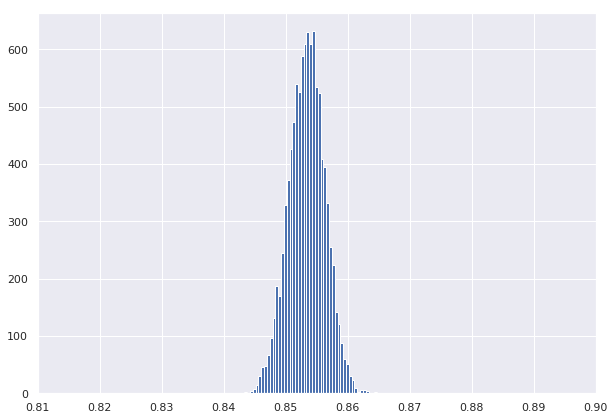

<Figure size 432x288 with 0 Axes>

In [29]:

plt.figure(figsize=(10,7))

plt.hist(bootstrapped_scores, bins=50)
plt.xticks(np.arange(0.81, 0.91, step=0.01))
# plt.title('')
plt.show()

plt.savefig("/home/marlan/Desktop/confidence_genomic.pdf", bbox_inches='tight', pad_inches=0.1)

In [30]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.848 - 0.859]
